In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource,  HoverTool, Legend
from bokeh.io import output_notebook
output_notebook()
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error,  mean_squared_error
import mlflow

Loading BokehJS ...

## Создание Base-line модели

In [2]:
df = pd.read_pickle('../data/CleanCarData.pkl')
df

,Car_Name,Year,Selling_Price,Present_Price,Driven_kms,Fuel_Type,Selling_type,Transmission,Owner
0,ritz,2014,3.349609,5.589844,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.750000,9.539062,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.250000,9.851562,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.849609,4.148438,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.601562,6.871094,42450,Diesel,Dealer,Manual,0
...,...,...,...,...,...,...,...,...,...
296,city,2016,9.500000,11.601562,33988,Diesel,Dealer,Manual,0
297,brio,2015,4.000000,5.898438,60000,Petrol,Dealer,Manual,0
298,city,2009,3.349609,11.000000,87934,Petrol,Dealer,Manual,0
299,city,2017,11.500000,12.500000,9000,Diesel,Dealer,Manual,0


In [3]:
df = df.rename(columns={'Present_Price': 'target'})
df = df.drop(columns=['Year'])
df

,Car_Name,Selling_Price,target,Driven_kms,Fuel_Type,Selling_type,Transmission,Owner
0,ritz,3.349609,5.589844,27000,Petrol,Dealer,Manual,0
1,sx4,4.750000,9.539062,43000,Diesel,Dealer,Manual,0
2,ciaz,7.250000,9.851562,6900,Petrol,Dealer,Manual,0
3,wagon r,2.849609,4.148438,5200,Petrol,Dealer,Manual,0
4,swift,4.601562,6.871094,42450,Diesel,Dealer,Manual,0
...,...,...,...,...,...,...,...,...
296,city,9.500000,11.601562,33988,Diesel,Dealer,Manual,0
297,brio,4.000000,5.898438,60000,Petrol,Dealer,Manual,0
298,city,3.349609,11.000000,87934,Petrol,Dealer,Manual,0
299,city,11.500000,12.500000,9000,Diesel,Dealer,Manual,0


In [4]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.25, random_state=2)

In [5]:
cat_features = X_train.select_dtypes(include=['category','object']).columns.to_list()
cat_features

['Car_Name', 'Fuel_Type', 'Selling_type', 'Transmission']

In [6]:
num_features = X_train.select_dtypes(include=['number']).columns.to_list()
num_features

['Selling_Price', 'Driven_kms', 'Owner']

In [7]:
s_scaler = StandardScaler()
l_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=99999999) 
regressor = RandomForestRegressor()

In [8]:
# Для удобной работы со столбцами
preprocessor = ColumnTransformer(
    transformers=[
        ('num', s_scaler, num_features),  # преобразования для числовых признаков
        ('cat', l_encoder, cat_features), # преобразования для категориальных признаков
    ],
    remainder='drop' ) # Удаляем столбцы, которые не затронуты преобразования

In [9]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                           ('model', regressor)])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Selling_Price',
                                                   'Driven_kms', 'Owner']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=99999999),
                                                  ['Car_Name', 'Fuel_Type',
                                                   'Selling_type',
                                                   'Transmission'])])),
                ('model', RandomForestRegressor())])

In [10]:
predictions = pipeline.predict(X_test) 

metrics = {}
metrics["mae"] = mean_absolute_error(y_test, predictions)   
metrics["mape"] = mean_absolute_percentage_error(y_test, predictions)
metrics["mse"] = mean_squared_error(y_test, predictions)

metrics


{'mae': 1.371212038886278,
 'mape': 0.9099791023013616,
 'mse': 3.521749787759028}

## Логируем с MLFlow

In [11]:
# Работаем с MLflow локально
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

registry_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"
tracking_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"

mlflow.set_tracking_uri(tracking_uri)   
mlflow.set_registry_uri(registry_uri)   

In [12]:
# название тестового эксперимента, запуска (run) внутри него, имени, под которым модель будет регистрироваться
EXPERIMENT_NAME = "Predict_price"
RUN_NAME = "baseline_model"
REGISTRY_MODEL_NAME = "car_model_rf"

In [13]:
# Обязательно логируем сигнатуру модели и пример входных данных. Подготовим их
from mlflow.models import infer_signature

signature =  infer_signature(model_input = X_train.head(5))
input_example = X_train.head(5)
req_file = '../requirements.txt'
# Параметры, котороые будут залогированы, можем задавать вручную или полностью взять из модели
params_dict = pipeline.get_params()




/home/Dmit/IIS/.my_venv/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


In [56]:
## Когда создаем новый эксперимент, то: 
experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)

# Впоследствии. чтобы добавлять запуски в этот же эксепримент мы должны получить его id:
#experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_params(params_dict)

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2024/11/14 20:38:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run baseline_model at: http://127.0.0.1:5000/#/experiments/2/runs/5b6bfc90180b423c918e3234bd6515a2.
2024/11/14 20:38:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2.


## Future Engineering

In [14]:
from sklearn.preprocessing import QuantileTransformer, SplineTransformer, PolynomialFeatures, MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer


X_train_fe_sklearn = X_train.copy()
X_test_fe_sklearn = X_test.copy()

In [15]:
num_features = ['Selling_Price', 'Driven_kms']

pf = PolynomialFeatures(degree=2)

kbd = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')



preprocessor_sklearn = ColumnTransformer(
    transformers=[
        ('num', s_scaler, num_features),  # преобразования для числовых признаков
        ('cat', l_encoder, cat_features), # преобразования для категориальных признаков
        ('poly', Pipeline([
                            ('poly_feat', pf),
                            ('scaler', s_scaler)]), num_features),
        ('k_bin', kbd, num_features)
    ],
    remainder='drop' ) # Удаляем столбцы, которые не затронуты преобразования


X_train_sklearn = preprocessor_sklearn.fit_transform(X_train_fe_sklearn)
X_test_sklearn = preprocessor_sklearn.fit_transform(X_test_fe_sklearn)

In [16]:
X_train_sklearn_df = pd.DataFrame(X_train_sklearn, columns = preprocessor_sklearn.get_feature_names_out())

X_test_sklearn_df = pd.DataFrame(X_test_sklearn, columns = preprocessor_sklearn.get_feature_names_out())

In [17]:

display(X_train_sklearn_df)

,num__Selling_Price,num__Driven_kms,cat__Car_Name,cat__Fuel_Type,cat__Selling_type,cat__Transmission,poly__1,poly__Selling_Price,poly__Driven_kms,poly__Selling_Price^2,poly__Selling_Price Driven_kms,poly__Driven_kms^2,k_bin__Selling_Price,k_bin__Driven_kms
0,-0.819553,-0.797744,22.0,2.0,1.0,0.0,0.0,-0.819553,-0.797744,-0.376286,-0.636605,-0.186065,0.0,0.0
1,-0.657343,-0.802502,34.0,2.0,1.0,1.0,0.0,-0.657343,-0.802502,-0.364830,-0.624404,-0.186163,0.0,0.0
2,0.470933,-0.541795,69.0,2.0,0.0,0.0,0.0,0.470933,-0.541795,0.016143,-0.252062,-0.173878,0.0,0.0
3,-0.069707,-0.043623,75.0,2.0,0.0,1.0,0.0,-0.069707,-0.043623,-0.232151,-0.074166,-0.111314,0.0,0.0
4,0.097877,-0.152412,49.0,2.0,0.0,1.0,0.0,0.097877,-0.152412,-0.168123,-0.047240,-0.129356,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,-0.172443,-0.043623,60.0,2.0,0.0,1.0,0.0,-0.172443,-0.043623,-0.265656,-0.143894,-0.111314,0.0,0.0
221,-0.088651,0.289428,74.0,2.0,0.0,0.0,0.0,-0.088651,0.289428,-0.238658,0.129525,-0.040865,0.0,0.0
222,0.480405,0.432187,53.0,2.0,0.0,1.0,0.0,0.480405,0.432187,0.021572,0.823156,-0.003644,0.0,0.0
223,0.536510,0.122902,58.0,1.0,0.0,1.0,0.0,0.536510,0.122902,0.054486,0.528061,-0.078957,0.0,0.0


In [18]:
pipeline_sklearn = Pipeline(steps=[
    ('transform', preprocessor_sklearn),
    ('model', regressor)
])

model_sklearn = pipeline_sklearn.fit(X_train, y_train)

predictions = pipeline_sklearn.predict(X_test) 
metrics = {}
metrics["mae"] = mean_absolute_error(y_test, predictions)   
metrics["mape"] = mean_absolute_percentage_error(y_test, predictions)
metrics["mse"] = mean_squared_error(y_test, predictions)

metrics

{'mae': 1.3669568088311597,
 'mape': 0.6840094286294216,
 'mse': 4.136079157694972}

In [19]:
# Посмотрим на тренировочные данные

transformed_data = pipeline_sklearn.named_steps['transform'].transform(X_train)

import pandas as pd
transformed_df = pd.DataFrame(transformed_data, columns=pipeline_sklearn.named_steps['transform'].get_feature_names_out())

display(transformed_df.head())
print(transformed_df.shape)

,num__Selling_Price,num__Driven_kms,cat__Car_Name,cat__Fuel_Type,cat__Selling_type,cat__Transmission,poly__1,poly__Selling_Price,poly__Driven_kms,poly__Selling_Price^2,poly__Selling_Price Driven_kms,poly__Driven_kms^2,k_bin__Selling_Price,k_bin__Driven_kms
0,-0.819553,-0.797744,22.0,2.0,1.0,0.0,0.0,-0.819553,-0.797744,-0.376286,-0.636605,-0.186065,0.0,0.0
1,-0.657343,-0.802502,34.0,2.0,1.0,1.0,0.0,-0.657343,-0.802502,-0.364830,-0.624404,-0.186163,0.0,0.0
2,0.470933,-0.541795,69.0,2.0,0.0,0.0,0.0,0.470933,-0.541795,0.016143,-0.252062,-0.173878,0.0,0.0
3,-0.069707,-0.043623,75.0,2.0,0.0,1.0,0.0,-0.069707,-0.043623,-0.232151,-0.074166,-0.111314,0.0,0.0
4,0.097877,-0.152412,49.0,2.0,0.0,1.0,0.0,0.097877,-0.152412,-0.168123,-0.047240,-0.129356,0.0,0.0


(225, 14)


In [20]:
# имена столбцов
col_names = preprocessor_sklearn.get_feature_names_out()
pd.DataFrame(col_names).to_csv("column_names.csv", index=False) # Сохраняем в файл

In [64]:
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
RUN_NAME = 'fe_sklearn'

input_example = X_train_sklearn_df.head(5)

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
# Параметры, котороые будут залогированы, можем задавать вручную или полностью взять из модели
params_dict = pipeline.get_params()

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact('column_names.csv', artifact_path = 'columns')
    mlflow.log_params(model_sklearn.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2024/11/14 20:41:43 WARNING mlflow.models.model: Failed to validate serving input example {
  "dataframe_split": {
    "columns": [
      "num__Selling_Price",
      "num__Driven_kms",
      "cat__Car_Name",
      "cat__Fuel_Type",
      "cat__Selling_type",
      "cat__Transmission",
      "poly__1",
      "poly__Selling_Price",
      "poly__Driven_kms",
      "poly__Selling_Price^2",
      "poly__Selling_Price Driven_kms",
      "poly__Driven_kms^2",
      "k_bin__Selling_Price",
      "k_bin__Driven_kms"
    ],
    "data": [
      [
        -0.8195532052678765,
        -0.7977443676065369,
        22.0,
        2.0,
        1.0,
        0.0,
        0.0,
        -0.8195532052678769,
        -0.7977443676065373,
        -0.3762856142137885,
        -0.6366050876597937,
        -0.18606482000981525,
        0.0,
        0.0
      ],
      [
        -0.6573429935532745,
        -0.8025022314379671,
        34.0,
        2.0,
        1.0,
        1.0,
        0.0,
        -0.65734299355

## Отбор наиболее важных признаков


In [21]:
from mlxtend.feature_selection import SequentialFeatureSelector 

sfs = SequentialFeatureSelector(RandomForestRegressor(n_estimators=3), 
                                k_features=4,
                                forward=True,
                                floating=False, # True to drop selected features
                                scoring='neg_mean_absolute_error',
                                cv=2)

sfs.fit(X_train_sklearn_df,y_train)

SequentialFeatureSelector(cv=2, estimator=RandomForestRegressor(n_estimators=3),
                          k_features=(4, 4), scoring='neg_mean_absolute_error')

In [22]:
selected_features_sfs = X_train_sklearn_df.loc[:, sfs.k_feature_names_]
selected_features_sfs

,num__Driven_kms,cat__Car_Name,poly__1,k_bin__Selling_Price
0,-0.797744,22.0,0.0,0.0
1,-0.802502,34.0,0.0,0.0
2,-0.541795,69.0,0.0,0.0
3,-0.043623,75.0,0.0,0.0
4,-0.152412,49.0,0.0,0.0
...,...,...,...,...
220,-0.043623,60.0,0.0,0.0
221,0.289428,74.0,0.0,0.0
222,0.432187,53.0,0.0,0.0
223,0.122902,58.0,0.0,0.0


In [23]:
rfe_sfs_idx = list(sfs.k_feature_idx_)
rfe_sfs_idx
rfe_sfs_col = list(sfs.k_feature_names_)
rfe_sfs_col

['num__Driven_kms', 'cat__Car_Name', 'poly__1', 'k_bin__Selling_Price']

In [ ]:
with open("rfe_sfs_cols.txt", "w") as output:
    output.write(str(rfe_sfs_col))

In [41]:
with open("rfe_sfs_idx.txt", "w") as output:
    output.write(str(rfe_sfs_idx))

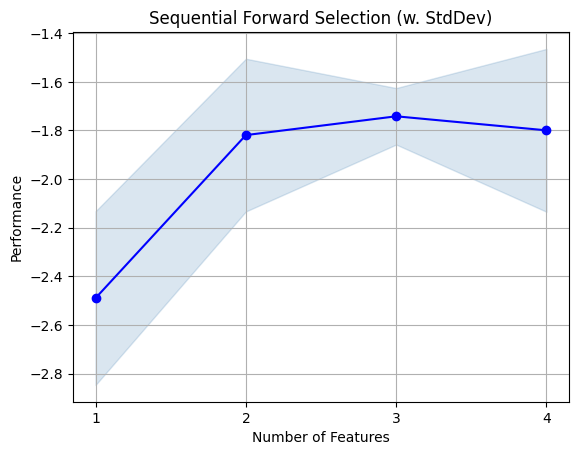

In [24]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()

In [25]:
class ColumnExtractor(object):

    def __init__(self, cols):
        self.cols = cols

    def transform(self, X):
        return X[:,self.cols]
    
    def fit(self, X, y=None):
        return self

In [26]:
rfe_sfs_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_sklearn), 
    ('rfe_extractor', ColumnExtractor(rfe_sfs_idx)),
    ('model', regressor)
])

rfe_sfs_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Selling_Price',
                                                   'Driven_kms']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=99999999),
                                                  ['Car_Name', 'Fuel_Type',
                                                   'Selling_type',
                                                   'Transmission']),
                                                 ('poly',
                                                  Pipeline(steps=[('poly_feat',
                                                                   PolynomialFeatures()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Selling_Price',
                                                   'Driven_kms']),
                                                 ('k_bin',
                                                  KBinsDiscretizer(encode='ordinal',
                                                                   n_bins=3,
                                                                   strategy='uniform'),
                                                  ['Selling_Price',
                                                   'Driven_kms'])])),
                ('rfe_extractor',
                 <__main__.ColumnExtractor object at 0x7bf3f406c140>),
                ('model', RandomForestRegressor())])

In [27]:
predictions_sfs = rfe_sfs_pipeline.predict(X_test)

metrics = {}
metrics["mae"] = mean_absolute_error(y_test, predictions_sfs)   
metrics["mape"] = mean_absolute_percentage_error(y_test, predictions_sfs)
metrics["mse"] = mean_squared_error(y_test, predictions_sfs)

metrics

{'mae': 2.5446955737733004,
 'mape': 2.0692751444129147,
 'mse': 15.180714989887118}

In [74]:
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
RUN_NAME = 'rfe_sfs_feature_selection'

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(rfe_sfs_pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact('rfe_sfs_cols.txt')
    mlflow.log_artifact('rfe_sfs_idx.txt')
    mlflow.log_params(model_sklearn.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2024/11/14 21:39:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run rfe_sfs_feature_selection at: http://127.0.0.1:5000/#/experiments/2/runs/39ff2d31d18e4228bbef3201ce4a862f.
2024/11/14 21:39:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2.


## Подбор оптимальных гиперпараметров

In [28]:
import optuna

/home/Dmit/IIS/.my_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [78]:
import optuna

def objective(trial):
    # Гиперпараметры для настройки
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    max_features = trial.suggest_float('max_features', 0.1, 1.0)

    # Создаем и обучаем модель
    opt_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor_sklearn), 
        ('model', RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features))
    ])
    
    opt_pipeline.fit(X_train, y_train)

    # Предсказание и расчет метрики MAE
    preds = opt_pipeline.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    return mae  # Минимизируем MAE


In [79]:
# Запускаем оптимизацию
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Выводим лучшие гиперпараметры
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2024-11-14 22:04:17,965] A new study created in memory with name: no-name-7c6f6fc2-77e4-4386-9462-ec2304b29bde
[I 2024-11-14 22:04:18,633] Trial 0 finished with value: 1.3807004512090562 and parameters: {'n_estimators': 188, 'max_depth': 17, 'max_features': 0.5463956354637921}. Best is trial 0 with value: 1.3807004512090562.
[I 2024-11-14 22:04:19,124] Trial 1 finished with value: 1.4278538379537926 and parameters: {'n_estimators': 226, 'max_depth': 7, 'max_features': 0.4002398358093846}. Best is trial 0 with value: 1.3807004512090562.
[I 2024-11-14 22:04:19,720] Trial 2 finished with value: 1.3971095518917092 and parameters: {'n_estimators': 232, 'max_depth': 19, 'max_features': 0.678254780508999}. Best is trial 0 with value: 1.3807004512090562.
[I 2024-11-14 22:04:20,190] Trial 3 finished with value: 1.4751886063723958 and parameters: {'n_estimators': 193, 'max_depth': 7, 'max_features': 0.7247996773378563}. Best is trial 0 with value: 1.3807004512090562.
[I 2024-11-14 22:04:20,75

Number of finished trials: 10
Best trial: {'n_estimators': 100, 'max_depth': 20, 'max_features': 0.8072727315456365}


In [81]:
# Используем оптимальные параметры
best_params = study.best_trial.params
opt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_sklearn),
    ('model', RandomForestRegressor(**best_params))
])

opt_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Selling_Price',
                                                   'Driven_kms']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=99999999),
                                                  ['Car_Name', 'Fuel_Type',
                                                   'Selling_type',
                                                   'Transmission']),
                                                 ('poly',
                                                  Pipeline(steps=[('poly_feat',
                                                                   PolynomialFeatures()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Selling_Price',
                                                   'Driven_kms']),
                                                 ('k_bin',
                                                  KBinsDiscretizer(encode='ordinal',
                                                                   n_bins=3,
                                                                   strategy='uniform'),
                                                  ['Selling_Price',
                                                   'Driven_kms'])])),
                ('model',
                 RandomForestRegressor(max_depth=20,
                                       max_features=0.8072727315456365))])

In [82]:
prediction = opt_pipeline.predict(X_test)

metrics = {}
metrics["mae"] = mean_absolute_error(y_test, prediction)   
metrics["mape"] = mean_absolute_percentage_error(y_test, prediction)
metrics["mse"] = mean_squared_error(y_test, prediction)

metrics

{'mae': 1.356242322419819,
 'mape': 0.7096607277627079,
 'mse': 3.614193406402558}

In [85]:
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
RUN_NAME = 'optuna_model'

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(opt_pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_params(model_sklearn.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2024/11/14 22:32:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run optuna_model at: http://127.0.0.1:5000/#/experiments/2/runs/6ea4d38f66964a03ac0a726ecf9cef59.
2024/11/14 22:32:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2.


## Наилучшая модель

In [42]:
X_full = pd.concat([X_train, X_test], axis=0)
y_full = pd.concat([y_train, y_test], axis=0)

In [47]:
X_train_fe_sklearn = X_full.copy()

In [48]:
num_features = ['Selling_Price', 'Driven_kms']

pf = PolynomialFeatures(degree=2)

kbd = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')



preprocessor_sklearn = ColumnTransformer(
    transformers=[
        ('num', s_scaler, num_features),  # преобразования для числовых признаков
        ('cat', l_encoder, cat_features), # преобразования для категориальных признаков
        ('poly', Pipeline([
                            ('poly_feat', pf),
                            ('scaler', s_scaler)]), num_features),
        ('k_bin', kbd, num_features)
    ],
    remainder='drop' ) # Удаляем столбцы, которые не затронуты преобразования


X_train_sklearn = preprocessor_sklearn.fit_transform(X_train_fe_sklearn)
X_train_sklearn_df = pd.DataFrame(X_train_sklearn, columns = preprocessor_sklearn.get_feature_names_out())

In [49]:
pipeline_sklearn = Pipeline(steps=[
    ('transform', preprocessor_sklearn),
    ('model', regressor)
])

model_sklearn = pipeline_sklearn.fit(X_full, y_full)



In [51]:
# имена столбцов
col_names = preprocessor_sklearn.get_feature_names_out()
pd.DataFrame(col_names).to_csv("column_names_best_model.csv", index=False) # Сохраняем в файл

In [ ]:
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
RUN_NAME = 'best_model'

input_example = X_train_sklearn_df.head(5)

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
# Параметры, котороые будут залогированы, можем задавать вручную или полностью взять из модели
params_dict = pipeline.get_params()

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_artifact('column_names.csv', artifact_path = 'columns')
    mlflow.log_params(model_sklearn.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2024/11/14 23:22:58 WARNING mlflow.models.model: Failed to validate serving input example {
  "dataframe_split": {
    "columns": [
      "num__Selling_Price",
      "num__Driven_kms",
      "cat__Car_Name",
      "cat__Fuel_Type",
      "cat__Selling_type",
      "cat__Transmission",
      "poly__1",
      "poly__Selling_Price",
      "poly__Driven_kms",
      "poly__Selling_Price^2",
      "poly__Selling_Price Driven_kms",
      "poly__Driven_kms^2",
      "k_bin__Selling_Price",
      "k_bin__Driven_kms"
    ],
    "data": [
      [
        -0.8240049383678791,
        -0.8409409409424701,
        31.0,
        2.0,
        1.0,
        0.0,
        0.0,
        -0.8240049383678794,
        -0.8409409409424702,
        -0.380713651245619,
        -0.620637512909156,
        -0.1918462419749236,
        0.0,
        0.0
      ],
      [
        -0.6526243791573298,
        -0.8460926279900902,
        46.0,
        2.0,
        1.0,
        1.0,
        0.0,
        -0.65262437915733